In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Ironhack/Neural networks/hypothyroid_clean.csv')
display(data.head())
print(data.shape)

,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti,binaryclass
0,1,0,0,0,0,1.30,2.5,109.0,Healthy
1,1,0,0,0,0,4.10,2.0,107.0,Healthy
2,0,0,0,0,0,0.98,2.0,120.0,Healthy
3,1,1,0,0,0,0.16,1.9,107.0,Healthy
4,1,0,0,0,0,0.72,1.2,70.0,Healthy


(3709, 9)


### Enconding features ### 

In [6]:
### Sex column

data["sex"] = data["sex"].replace({"F":1, "M":0})

In [7]:
### Other categoricals with f, t

cols = ["on_thyroxine", "on_antithyroid_medication", "pregnant", "goitre"]
for col in cols:
    data[col] = data[col].replace({"t":1, "f":0})

In [8]:
data.head()

,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti,binaryclass
0,1,0,0,0,0,1.30,2.5,109.0,Healthy
1,1,0,0,0,0,4.10,2.0,107.0,Healthy
2,0,0,0,0,0,0.98,2.0,120.0,Healthy
3,1,1,0,0,0,0.16,1.9,107.0,Healthy
4,1,0,0,0,0,0.72,1.2,70.0,Healthy


### X, y split ###

In [9]:
X = data.drop("binaryclass", axis = 1)
y = data["binaryclass"]

### Train test split ### 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape X train:', X_train.shape)
print('Shape X test:', X_test.shape)
print('Shape y train:', y_train.shape)
print('Shape y test:', y_test.shape)

Shape X train: (2967, 8)
Shape X test: (742, 8)
Shape y train: (2967,)
Shape y test: (742,)


In [11]:
X_train.head()

,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti
964,1,0,0,0,0,0.20,3.2,107.0
507,1,1,0,0,0,0.61,1.6,127.0
7,1,0,0,0,0,2.20,0.6,115.0
2123,1,0,0,0,0,0.15,2.7,91.0
2833,0,0,0,0,0,1.10,2.4,109.0


### MinMax scaler ### 

In [12]:
scaler_num = MinMaxScaler().fit(X_train)
X_train_scaled = scaler_num.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
print(X_train_scaled.shape)
X_train_scaled.head()

(2967, 8)


,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti
964,1.0,0.0,0.0,0.0,0.0,0.000368,0.298578,0.267176
507,1.0,1.0,0.0,0.0,0.0,0.001142,0.146919,0.318066
7,1.0,0.0,0.0,0.0,0.0,0.004142,0.052133,0.287532
2123,1.0,0.0,0.0,0.0,0.0,0.000274,0.251185,0.226463
2833,0.0,0.0,0.0,0.0,0.0,0.002066,0.222749,0.272265


In [13]:
X_test_scaled = scaler_num.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index=X_test.index)
print(X_test_scaled.shape)
X_test_scaled.head()

(742, 8)


,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti
1783,0.0,0.0,0.0,0.0,0.0,0.000462,0.146919,0.307888
1929,1.0,0.0,0.0,0.0,0.0,0.016217,0.345972,0.195929
2917,0.0,0.0,0.0,0.0,0.0,0.004708,0.213270,0.246819
787,1.0,0.0,0.0,0.0,0.0,0.002632,0.184834,0.267176
798,1.0,0.0,0.0,0.0,0.0,0.005462,0.222749,0.244275


### Class imbalance: SMOTE ###

In [14]:
sm = SMOTE(random_state=50, k_neighbors=3)
X_train_scaled_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
print('X shape before using SMOTE:', X_train_scaled.shape)
print('X shape after using SMOTE:', X_train_scaled_sm.shape)
print('')
print('Y value counts:\n', y_train_sm.value_counts())

X shape before using SMOTE: (2967, 8)
X shape after using SMOTE: (5482, 8)

Y value counts:
 Healthy     2741
Diseased    2741
Name: binaryclass, dtype: int64


In [15]:
X_train_scaled_sm.head()

,sex,on_thyroxine,on_antithyroid_medication,pregnant,goitre,tsh,t3,fti
0,1.0,0.0,0.0,0.0,0.0,0.000368,0.298578,0.267176
1,1.0,1.0,0.0,0.0,0.0,0.001142,0.146919,0.318066
2,1.0,0.0,0.0,0.0,0.0,0.004142,0.052133,0.287532
3,1.0,0.0,0.0,0.0,0.0,0.000274,0.251185,0.226463
4,0.0,0.0,0.0,0.0,0.0,0.002066,0.222749,0.272265


In [16]:
y_train_sm

0        Healthy
1        Healthy
2        Healthy
3        Healthy
4        Healthy
          ...   
5477    Diseased
5478    Diseased
5479    Diseased
5480    Diseased
5481    Diseased
Name: binaryclass, Length: 5482, dtype: object

### Encoding y ###

In [17]:
y_train_sm = y_train_sm.replace({"Diseased":1, "Healthy":0})
y_train_sm

0       0
1       0
2       0
3       0
4       0
       ..
5477    1
5478    1
5479    1
5480    1
5481    1
Name: binaryclass, Length: 5482, dtype: int64

In [18]:
y_test = y_test.replace({"Diseased":1, "Healthy":0})
y_test

1783    0
1929    1
2917    0
787     0
798     0
       ..
1954    0
596     0
3690    1
3021    0
296     0
Name: binaryclass, Length: 742, dtype: int64

### Neural Network: Keras ###

In [19]:
early_stopping = EarlyStopping(patience=20)
model = keras.Sequential()
model.add(Dense(units = 32,input_dim = X_train_scaled_sm.shape[1],activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(units = 16,activation='relu'))
model.add(Dense(units = 1, activation='sigmoid', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'] 
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [20]:
checkpoint_path = '/content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

In [21]:
history = model.fit(
    X_train_scaled_sm, 
    y_train_sm, 
    epochs=60, 
    validation_split=0.20, 
    batch_size=10, 
    verbose=2,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/60

Epoch 1: saving model to /content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5
439/439 - 2s - loss: 0.6402 - accuracy: 0.6365 - val_loss: 0.8416 - val_accuracy: 0.1768 - 2s/epoch - 5ms/step
Epoch 2/60

Epoch 2: saving model to /content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5
439/439 - 1s - loss: 0.5495 - accuracy: 0.7220 - val_loss: 0.6241 - val_accuracy: 0.6089 - 883ms/epoch - 2ms/step
Epoch 3/60

Epoch 3: saving model to /content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5
439/439 - 1s - loss: 0.4606 - accuracy: 0.7799 - val_loss: 0.6714 - val_accuracy: 0.5770 - 898ms/epoch - 2ms/step
Epoch 4/60

Epoch 4: saving model to /content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5
439/439 - 1s - loss: 0.3957 - accuracy: 0.8242 - val_loss: 0.5576 - val_accuracy: 0.6746 - 871ms/epoch - 2ms/step
Epoch 5/60

Epoch 5: saving model to /content/drive/MyDrive/Ironhack/Neural networks/keras.hdf5
439/439 - 1s - loss: 0.3459 - accuracy: 0.8506 - val_loss: 0.4078 -

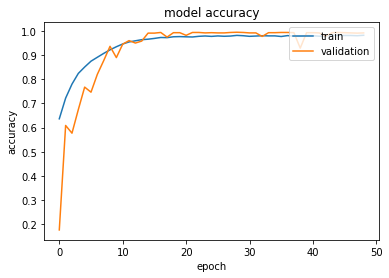

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import f1_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The F1 score is: {:.2f}".format(f1_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The F1 score is: {:.2f}".format(f1_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [43]:
y_pred_train = model.predict(X_train_scaled_sm) 
y_pred_test  = model.predict(X_test_scaled) 


In [44]:
y_pred_train

array([[3.9731829e-05],
       [9.5537928e-07],
       [4.2083859e-04],
       ...,
       [8.1780601e-01],
       [8.9861226e-01],
       [9.9678910e-01]], dtype=float32)

In [45]:
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test  = (y_pred_test > 0.5).astype(int)

In [46]:
model_performance_class(y_train_sm, y_pred_train, y_test, y_pred_test)

Results obtained for the TRAIN SET
The F1 score is: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2741
           1       0.99      0.99      0.99      2741

    accuracy                           0.99      5482
   macro avg       0.99      0.99      0.99      5482
weighted avg       0.99      0.99      0.99      5482

Results obtained for the TEST SET
The F1 score is: 0.92
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       677
           1       0.90      0.94      0.92        65

    accuracy                           0.99       742
   macro avg       0.95      0.96      0.95       742
weighted avg       0.99      0.99      0.99       742



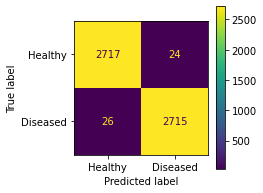

In [54]:
cm_train = confusion_matrix(y_train_sm, y_pred_train)
disp = ConfusionMatrixDisplay(cm_train, display_labels = ["Healthy", "Diseased"]);
disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(3)
fig.set_figheight(3)

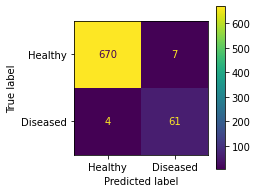

In [53]:
cm_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm_test, display_labels = ["Healthy", "Diseased"]);
disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(3)
fig.set_figheight(3)